### 1. Install Dependencies

In [1]:
!pip install gymnasium
!pip install ale-py
!pip install torch
!pip install numpy
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 784.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

### 2. Import Required Libraries

In [2]:
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import collections
import matplotlib.pyplot as plt

### 3.Test Atari Environment

Observation Space: (250, 160, 3)
Action Space: 5
Action meaning: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN']


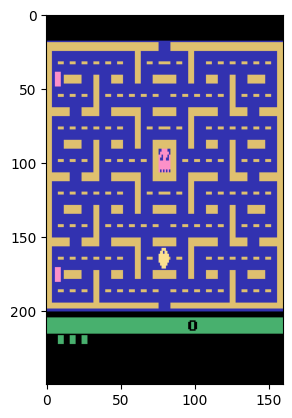

In [3]:
env = gym.make("ALE/Pacman-v5")  # Load Atari Pacman
obs, info = env.reset()  # Reset environment and get initial observation
env.close()

print("Observation Space:", env.observation_space.shape)  # (210, 160, 3) -> RGB Image
print("Action Space:", env.action_space.n)  # 5 possible actions
print("Action meaning:", env.unwrapped.get_action_meanings()) # action meaning
plt.imshow(obs) # show obs as a frame

Run a random policy

In [4]:
env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")

# create video recorder
env = gym.wrappers.RecordVideo(
    env,
    video_folder="videos", # define folder to save video
    name_prefix="video-",
)

obs, info = env.reset()
for _ in range(10):
    action = env.action_space.sample()  # Random action
    next_obs, reward, done, _, _ = env.step(action)  # Take action
    print(action, reward, done)
    if done:
        env.reset()
env.close()

6 0.0 False
0 0.0 False
4 0.0 False
2 0.0 False
7 0.0 False
5 0.0 False
5 0.0 False
2 0.0 False
3 0.0 False
6 0.0 False


### 4. Preprocess Atari Frames

Atari environments return RGB images. We need to:
- Resize to 84x84
- Convert them to grayscale
- Stack 4 frames to capture motion



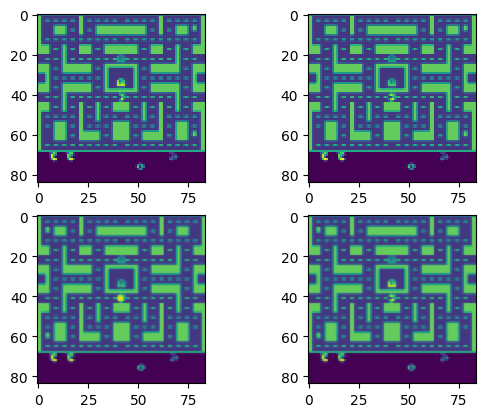

In [5]:
env = gym.make("ALE/MsPacman-v5")
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayscaleObservation(env)
env = gym.wrappers.FrameStackObservation(env, 4)
obs, info = env.reset()
for _ in range(10):
    action = env.action_space.sample()  # Random action
    obs, reward, done, _, _ = env.step(action)  # Take action
env.close()

# obs is as a stack of 4 frames
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(obs[0])
axes[0, 1].imshow(obs[1])
axes[1, 0].imshow(obs[2])
axes[1, 1].imshow(obs[3])
plt.show()

### 5. Define the Q-Network (CNN-based)

Atari games involve image inputs, so we use a **Convolutional Neural Network (CNN)** instead of a fully connected network.

In [6]:
class DQN(nn.Module):
    def __init__(self, action_dim):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, action_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # No activation (raw Q-values)

### 6. Experience Replay Buffer

In [7]:
class ReplayBuffer:
    def __init__(self, device, capacity=100000):
        self.device = device
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float).to(self.device),
            torch.tensor(np.array(actions), dtype=torch.long).to(self.device),
            torch.tensor(np.array(rewards), dtype=torch.float).to(self.device),
            torch.tensor(np.array(next_states), dtype=torch.float).to(self.device),
            torch.tensor(np.array(dones), dtype=torch.float).to(self.device),
        )

    def __len__(self):
        return len(self.buffer)

### 7. Define DQN Agent

In [8]:
class DQNAgent:
    def __init__(self, device, action_dim):
        self.device = device
        self.q_network = DQN(action_dim).to(self.device)
        self.target_network = DQN(action_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0001)
        self.replay_buffer = ReplayBuffer(self.device)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05
        self.batch_size = 64
        self.start_training = 10000
        self.train_every = 4
        self.update_target_every = 1000
        self.step_count = 0

    def select_action(self, state):
        """Epsilon-Greedy Policy"""
        if random.random() < self.epsilon:
            return random.randint(0, action_dim - 1)
        else:
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)
            q_values = self.q_network(state)
            return torch.argmax(q_values).item()

    def train(self):

        self.step_count += 1

        if self.step_count < self.start_training:
            return

        if self.step_count % self.train_every == 0:
            states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.step_count % self.update_target_every == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


### 8. Train the Agent

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("ALE/MsPacman-v5")
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayscaleObservation(env)
env = gym.wrappers.FrameStackObservation(env, 4)

action_dim = env.action_space.n
agent = DQNAgent(device, action_dim)

num_episodes = 1000 #1000
reward_history = []

for episode in range(num_episodes):
    obs, _ = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(obs)
        next_obs, reward, done, _, _ = env.step(action)
        agent.replay_buffer.push(obs, action, reward, next_obs, done)
        agent.train()

        obs = next_obs
        total_reward += reward
        if done:
            break

    reward_history.append(total_reward)
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

env.close()

Episode 0, Reward: 230.0, Epsilon: 1.00
Episode 1, Reward: 180.0, Epsilon: 1.00
Episode 2, Reward: 290.0, Epsilon: 1.00
Episode 3, Reward: 1110.0, Epsilon: 1.00
Episode 4, Reward: 220.0, Epsilon: 1.00
Episode 5, Reward: 370.0, Epsilon: 1.00
Episode 6, Reward: 290.0, Epsilon: 1.00
Episode 7, Reward: 290.0, Epsilon: 1.00
Episode 8, Reward: 230.0, Epsilon: 1.00
Episode 9, Reward: 300.0, Epsilon: 1.00
Episode 10, Reward: 310.0, Epsilon: 1.00
Episode 11, Reward: 210.0, Epsilon: 1.00
Episode 12, Reward: 330.0, Epsilon: 1.00
Episode 13, Reward: 280.0, Epsilon: 1.00
Episode 14, Reward: 230.0, Epsilon: 1.00
Episode 15, Reward: 300.0, Epsilon: 1.00
Episode 16, Reward: 250.0, Epsilon: 1.00
Episode 17, Reward: 340.0, Epsilon: 1.00
Episode 18, Reward: 290.0, Epsilon: 1.00
Episode 19, Reward: 250.0, Epsilon: 0.38
Episode 20, Reward: 110.0, Epsilon: 0.08
Episode 21, Reward: 300.0, Epsilon: 0.05
Episode 22, Reward: 1020.0, Epsilon: 0.05
Episode 23, Reward: 1210.0, Epsilon: 0.05
Episode 24, Reward: 410

### 9. Plot Training Results

In [ ]:
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN Training on Atari Pacman")
plt.show()

### 10. Evaluate the DQA agent

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")

# if you want to see the recored videos
env = gym.wrappers.RecordVideo(
    env,
    video_folder="videos", # define folder to save video
    name_prefix="video-",
)

env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayscaleObservation(env)
env = gym.wrappers.FrameStackObservation(env, 4)

num_episodes = 10
reward_history = []

for episode in range(num_episodes):
    obs, _ = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(obs)
        next_obs, reward, done, _, _ = env.step(action)
        obs = next_obs
        total_reward += reward
        if done:
            break

    reward_history.append(total_reward)
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

env.close()
print(f"Average Reward: {np.mean(reward_history):2f}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 0, Reward: 260.0, Epsilon: 1.00
Episode 1, Reward: 440.0, Epsilon: 1.00
Episode 2, Reward: 280.0, Epsilon: 1.00
Episode 3, Reward: 200.0, Epsilon: 1.00
Episode 4, Reward: 220.0, Epsilon: 1.00
Episode 5, Reward: 200.0, Epsilon: 1.00
Episode 6, Reward: 310.0, Epsilon: 1.00
Episode 7, Reward: 160.0, Epsilon: 1.00
Episode 8, Reward: 300.0, Epsilon: 1.00
Episode 9, Reward: 170.0, Epsilon: 1.00
Average Reward: 254.000000
